<a href="https://colab.research.google.com/github/o-flores/MVP-ML/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTACOES NECESSARIAS

In [1]:
# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import seaborn as sns

IMPORTACAO DO DATASET

In [3]:
# Importando dados do repositorio
# Meaning of rows - https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

data_url = "https://raw.githubusercontent.com/o-flores/MVP-ML/refs/heads/main/api/data/model.csv"

# Lendo arquivo
df = pd.read_csv(data_url, delimiter=',', index_col=0)

# Mostra dados do dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1611 entries, 1111 to 860
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1572 non-null   object 
 1   Age                             1572 non-null   float64
 2   Height                          1579 non-null   float64
 3   Weight                          1579 non-null   float64
 4   family_history_with_overweight  1580 non-null   object 
 5   FAVC                            1569 non-null   object 
 6   FCVC                            1572 non-null   float64
 7   NCP                             1573 non-null   float64
 8   CAEC                            1576 non-null   object 
 9   SMOKE                           1586 non-null   object 
 10  CH2O                            1583 non-null   float64
 11  SCC                             1573 non-null   object 
 12  FAF                             1570 

In [4]:
# Limpar dados nulos
df.dropna(inplace=True)

# Verificando se há ainda valores nulos
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 1501 entries, 1111 to 860
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1501 non-null   object 
 1   Age                             1501 non-null   float64
 2   Height                          1501 non-null   float64
 3   Weight                          1501 non-null   float64
 4   family_history_with_overweight  1501 non-null   object 
 5   FAVC                            1501 non-null   object 
 6   FCVC                            1501 non-null   float64
 7   NCP                             1501 non-null   float64
 8   CAEC                            1501 non-null   object 
 9   SMOKE                           1501 non-null   object 
 10  CH2O                            1501 non-null   float64
 11  SCC                             1501 non-null   object 
 12  FAF                             1501 

,0
Gender,0
Age,0
Height,0
Weight,0
family_history_with_overweight,0
FAVC,0
FCVC,0
NCP,0
CAEC,0
SMOKE,0


In [5]:
# Verificando os valores únicos das colunas de tipo object
list_of_object_columns = ['Gender','family_history_with_overweight', 'FAVC','CAEC', 'SMOKE','SCC','CALC','MTRANS','NObeyesdad' ]
for column in list_of_object_columns:
  print(column, df[column].unique())
  print(f"Verificando valores únicos de: {column}")

  # Quantidade de ocorrências
  value_counts = df[column].value_counts()
  print("Ocorrências:")
  print(value_counts)

  # Calculate proportions
  proportions = df[column].value_counts(normalize=True)
  print("Proporções:")
  print(proportions)
  print("\n")


Gender ['Male' 'Female']
Verificando valores únicos de: Gender
Ocorrências:
Gender
Male      755
Female    746
Name: count, dtype: int64
Proporções:
Gender
Male      0.502998
Female    0.497002
Name: proportion, dtype: float64


family_history_with_overweight ['yes' 'no']
Verificando valores únicos de: family_history_with_overweight
Ocorrências:
family_history_with_overweight
yes    1235
no      266
Name: count, dtype: int64
Proporções:
family_history_with_overweight
yes    0.822785
no     0.177215
Name: proportion, dtype: float64


FAVC ['yes' 'no']
Verificando valores únicos de: FAVC
Ocorrências:
FAVC
yes    1340
no      161
Name: count, dtype: int64
Proporções:
FAVC
yes    0.892738
no     0.107262
Name: proportion, dtype: float64


CAEC ['Sometimes' 'Always' 'no' 'Frequently']
Verificando valores únicos de: CAEC
Ocorrências:
CAEC
Sometimes     1265
Frequently     164
Always          39
no              33
Name: count, dtype: int64
Proporções:
CAEC
Sometimes     0.842771
Frequently   

In [6]:
# Transformar colunas em categorias
# Dividir os meios de transporte em duas categorias -> ativos e não ativos
active_modes = ['Walking', 'Bike']

# Dividir os niveis de obesidade em duas categorias -> obeso e não obeso
obesity = ['Overweight_Level_I', 'Obesity_Type_I', 'Overweight_Level_II',  'Obesity_Type_II', 'Obesity_Type_III']

# Mapeando categorias binarias
binary_map = {'yes': 1, 'no': 0}
gender_map = {'Male': 1, 'Female': 0}

# Transformando colunas binarias em categorias
df['family_history_with_overweight'] = df['family_history_with_overweight'].map(binary_map)
df['FAVC'] = df['FAVC'].map(binary_map)
df['SMOKE'] = df['SMOKE'].map(binary_map)
df['SCC'] = df['SCC'].map(binary_map)
df['Gender'] = df['Gender'].map(gender_map)

# Colunas CALC e CAEC podem ser divididas em duas -> favorece positivamente para a obesidade ('Sometimes', 'Always', 'Frequently') e não favorece ('no')
df['CALC'] = df['CALC'].apply(lambda x: 0 if x == 'no' else 1)
df['CAEC'] = df['CAEC'].apply(lambda x: 0 if x == 'no' else 1)

# Criando uma coluna nova que transforma a coluna de meios de transporte em categorias
df['MTRANS_active'] = df['MTRANS'].isin(active_modes).astype(int)

# Criando uma coluna nova que transforma a coluna de nível de obesidade em categorias
df['IS_OBESE'] = df['NObeyesdad'].isin(obesity).astype(int)

# Dropando as colunas que foram transformadas e não serão mais usadas no modelo
df = df.drop(columns=['MTRANS', 'NObeyesdad'], axis=1)


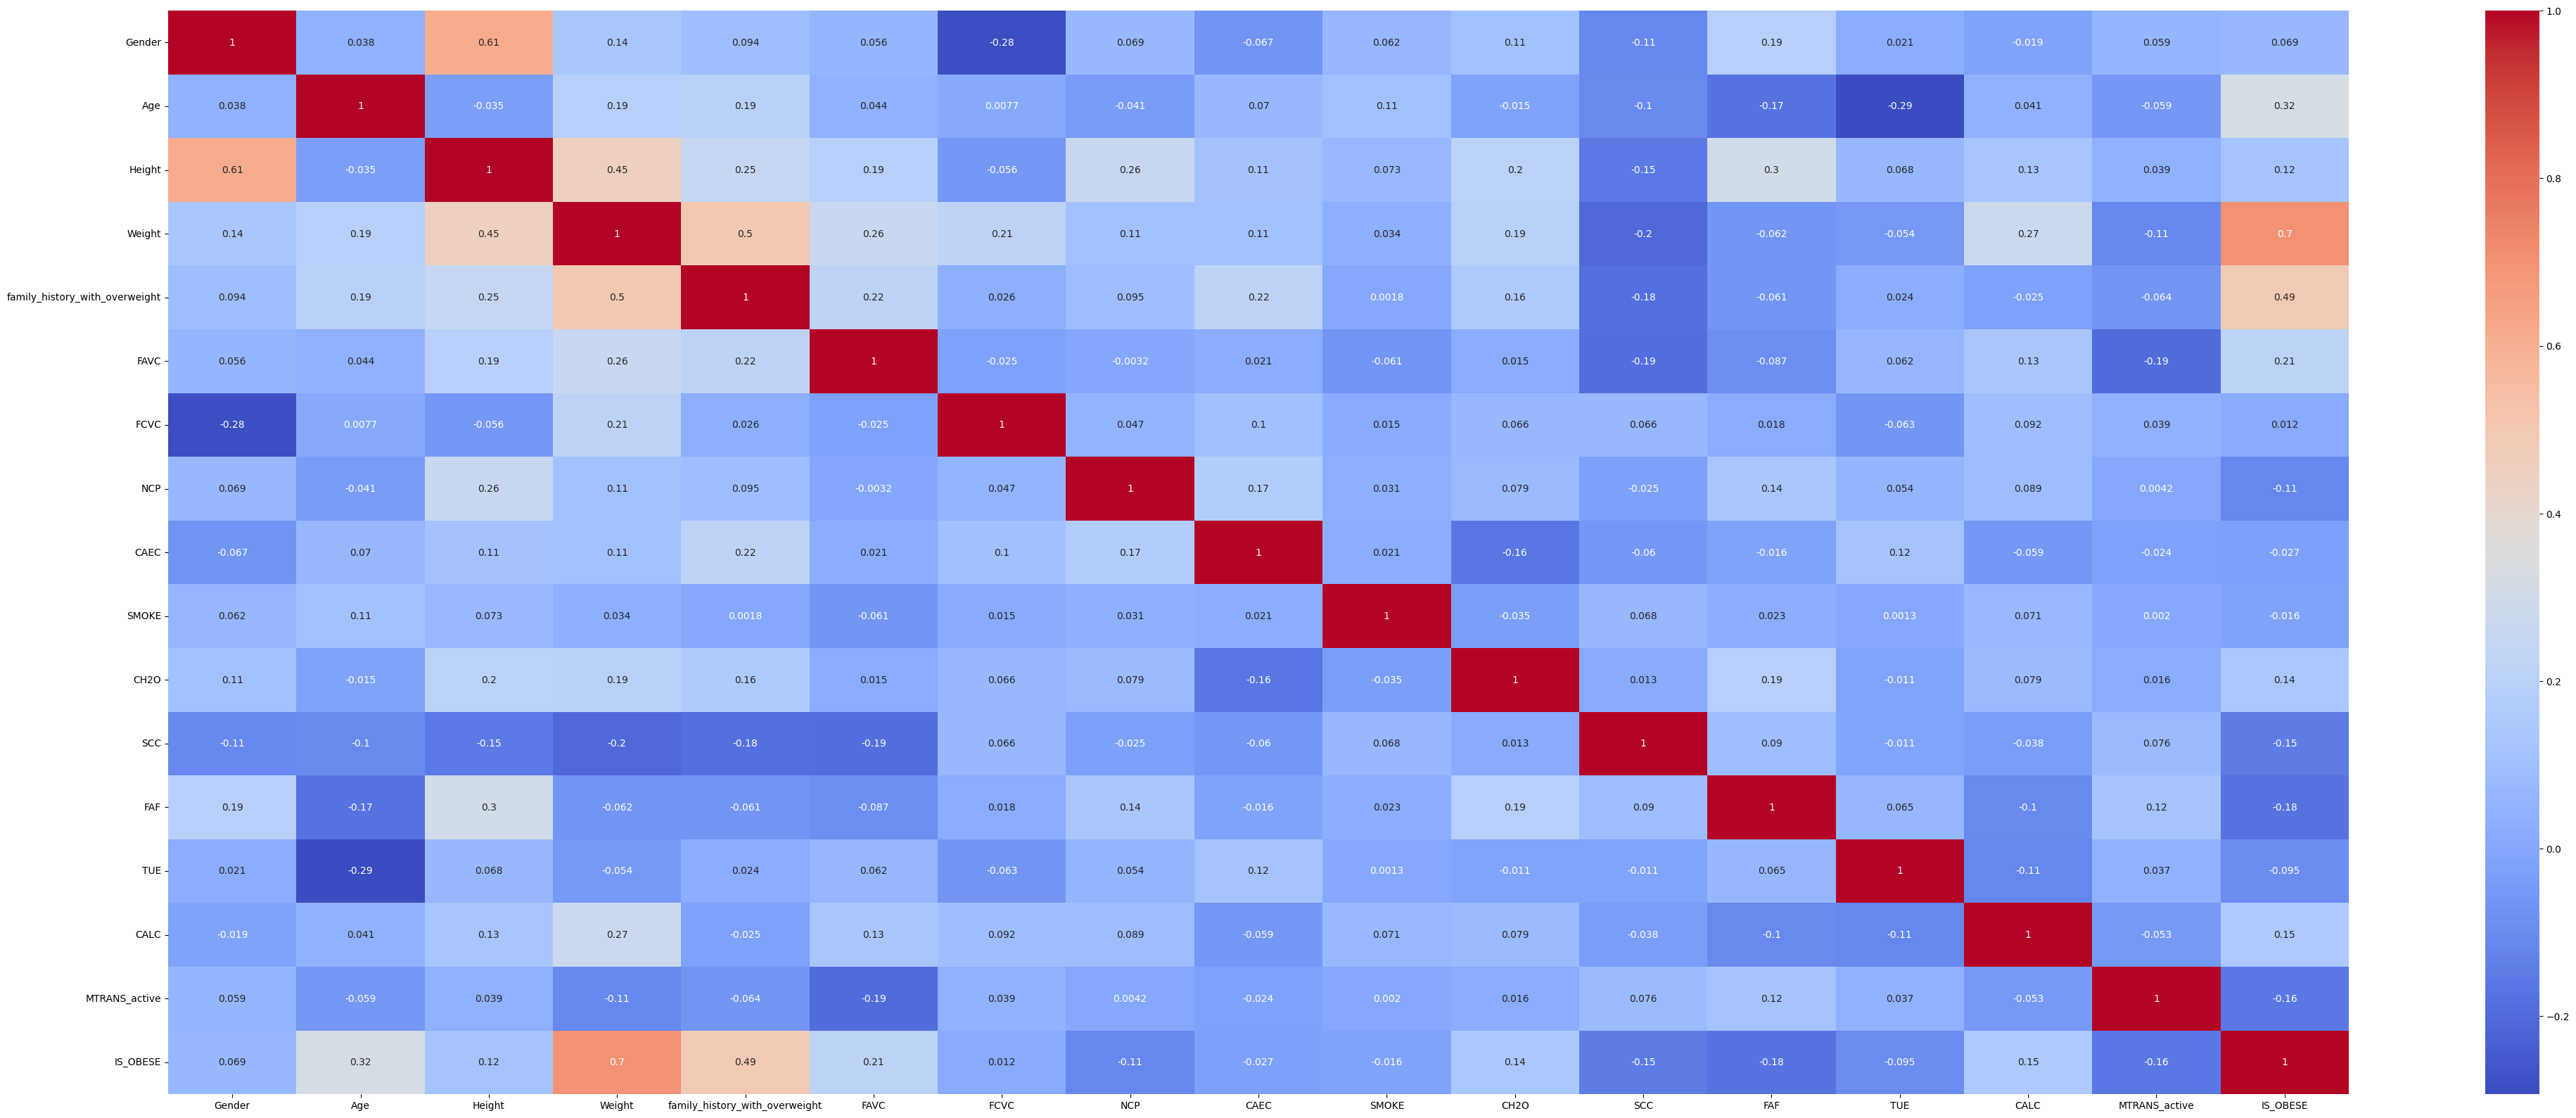

In [7]:
# Visualizar a correlação das colunas
plt.figure(figsize=(50,20))
corr=df.corr()
sns.heatmap(corr,annot=True,cmap='coolwarm')
plt.show()

In [8]:
# Como visto na figura acima o peso possui uma correlação muito alta com o target 'IS_OBESE'. Portanto para fins de estudo iremos dropar a coluna 'Weight' para o treinamento do modelo

df = df.drop(columns=['Weight'], axis=1)
df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 1501 entries, 1111 to 860
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1501 non-null   int64  
 1   Age                             1501 non-null   float64
 2   Height                          1501 non-null   float64
 3   family_history_with_overweight  1501 non-null   int64  
 4   FAVC                            1501 non-null   int64  
 5   FCVC                            1501 non-null   float64
 6   NCP                             1501 non-null   float64
 7   CAEC                            1501 non-null   int64  
 8   SMOKE                           1501 non-null   int64  
 9   CH2O                            1501 non-null   float64
 10  SCC                             1501 non-null   int64  
 11  FAF                             1501 non-null   float64
 12  TUE                             1501 

In [9]:
# Separação em conjunto de treino e conjunto de teste com holdout
test_size = 0.20 # tamanho do conjunto de teste
seed = 42 # semente aleatória

# Separação em conjuntos de treino e teste
array = df.values
X = array[:, :-1]
y = array[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 20
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

KNN-orig: 0.877
CART-orig: 0.875
NB-orig: 0.811
SVM-orig: 0.739
KNN-padr: 0.887
CART-padr: 0.869
NB-padr: 0.811
SVM-padr: 0.878
KNN-norm: 0.883
CART-norm: 0.872
NB-norm: 0.811
SVM-norm: 0.865


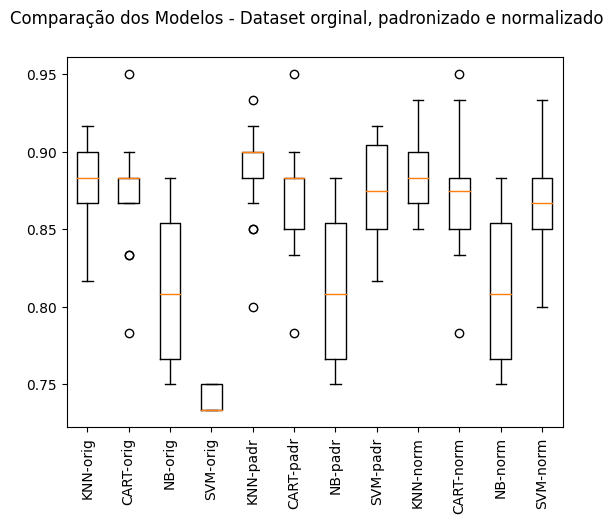

In [10]:
np.random.seed(42) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Algoritmos que serão testados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão testadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))


# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f" % (name, cv_results.mean())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

In [11]:
# A maior acurácia foi do algoritmo KNN, portanto iremos continuar com ele para criar o nosso modelo
# Tuning do KNN

np.random.seed(42) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Criando os pipelines com transformação e sem transformação para verificação da maior acurácia
pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

# Grid de parâmetros do KNN que serão otimizados
param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
    'KNN__weights' : ['uniform','distance'],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    print("%s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

knn-orig - Melhor: 0.896667 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 7, 'KNN__weights': 'distance'}
knn-padr - Melhor: 0.908333 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 5, 'KNN__weights': 'distance'}
knn-norm - Melhor: 0.903333 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 11, 'KNN__weights': 'distance'}


In [13]:
# Como pode ser observado acima, o modelo com melhor performance foi o KNN com o use de dados padronizados. Portando usaremos ele como o nosso modelo
model = KNeighborsClassifier(metric='manhattan', n_neighbors=5, weights='distance')

# Predição do modelo com valores não vistos
pipeline_test = Pipeline(steps=[('StandardScaler', StandardScaler()), ('KNN', model)])
pipeline_test.fit(X_train, y_train)
predictions = pipeline_test.predict(X_test)
print(accuracy_score(y_test, predictions))


0.893687707641196


In [14]:
# Treinamento do modelo com todos os valores
pipeline = Pipeline(steps=[('StandardScaler', StandardScaler()), ('KNN', model)])
pipeline.fit(X, y)


Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('KNN',
                 KNeighborsClassifier(metric='manhattan', weights='distance'))])

In [15]:
# Exportando modelo e pipeline
from pickle import dump
import sklearn as sklearn

# Salva o modelo
model_filename = 'model.pkl'
dump(model, open(model_filename, 'wb'))

# Salva o pipeline
pipeline_filename = 'pipeline.pkl'
dump(pipeline, open(pipeline_filename, 'wb'))


# CONCLUSÕES


Neste projeto, abordamos o problema da previsão de níveis de obesidade por meio de técnicas de machine learning, utilizando um conjunto de dados que exclui a variável de peso. Essa escolha permitiu que explorássemos a eficácia de outros fatores, como idade, gênero, dieta e atividade física, em prever a condição de obesidade. O modelo foi treinado utilizando algoritmos clássicos, como KNN, Árvores de Decisão, Naive Bayes e SVM, e a avaliação resultou em uma acurácia significativa, demonstrando que é possível realizar previsões robustas mesmo sem uma das variáveis mais esperadas, como o peso.

A análise dos resultados revelou que as variáveis escolhidas se mostraram relevantes para a classificação, o que reforça a importância de considerar uma gama diversificada de fatores ao abordar questões de saúde pública. Além disso, a implementação de técnicas de normalização e otimização de hiperparâmetros contribuiu para melhorar o desempenho do modelo.

